In [62]:
%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
import sys
import os

# 현재 작업 디렉토리의 상위 디렉토리를 Python 경로에 추가
sys.path.append(os.path.abspath('.'))
# 또는
sys.path.append(os.path.dirname(os.getcwd()))

# 이제 dismod_mr_pymc5를 import 해보세요
import numpy as np, matplotlib.pyplot as plt, pandas as pd, pymc as pm
import dismod_mr_pymc5

In [66]:
mr_model = dismod_mr_pymc5.data.load('amd_sim_data_Intermediate')
mr_model.keep(areas=['Global'], sexes=['Female', 'Male', 'Both'])


kept 207 rows of data


In [67]:
summary = mr_model.input_data.groupby('data_type')['value'].describe()
np.round(summary,3).sort_values('count', ascending=False)

,count,mean,std,min,25%,50%,75%,max
data_type,,,,,,,,
p,207.0,0.111,0.097,0.0,0.036,0.079,0.154,0.44


In [68]:
groups = mr_model.get_data('p').groupby('area')
print(np.round_(groups['value'].describe(),3).sort_values('50%', ascending=False))

                            count   mean    std    min    25%    50%    75%   
area                                                                          
Nepal                         5.0  0.341  0.016  0.320  0.330  0.343  0.354  \
Iceland                       5.0  0.227  0.107  0.109  0.130  0.239  0.295   
Japan                        19.0  0.201  0.128  0.013  0.112  0.181  0.296   
China                        24.0  0.125  0.068  0.014  0.059  0.131  0.172   
Taiwan (Province of China)   10.0  0.136  0.104  0.000  0.062  0.098  0.221   
Australia                    13.0  0.103  0.059  0.025  0.053  0.093  0.147   
Germany                       3.0  0.098  0.067  0.037  0.062  0.086  0.128   
Italy                        14.0  0.101  0.056  0.033  0.060  0.080  0.145   
Netherlands                   8.0  0.089  0.059  0.034  0.040  0.080  0.112   
India                        10.0  0.065  0.034  0.000  0.045  0.074  0.089   
Singapore                    11.0  0.088  0.067  0.0

In [69]:
countries = ['United States of America']
c = {}
for i, c_i in enumerate(countries):
    c[i] = groups.get_group(c_i)

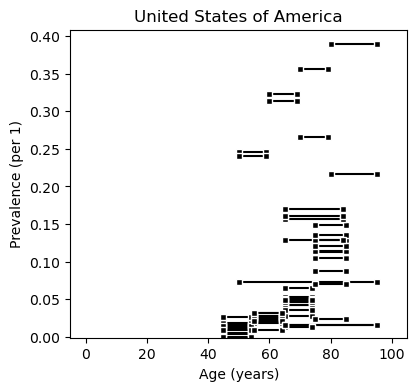

In [70]:
ax = None
plt.figure(figsize=(10,4))
for i, c_i in enumerate(countries):
    ax = plt.subplot(1,2,1+i, sharey=ax, sharex=ax)
    dismod_mr_pymc5.plot.data_bars(c[i])
    plt.xlabel('Age (years)')
    plt.ylabel('Prevalence (per 1)')
    plt.title(c_i)
plt.axis(ymin=-.001, xmin=-5, xmax=105)
plt.subplots_adjust(wspace=.3)

In [71]:
# remove fixed effects for this example, I will return to them below
mr_model.input_data = mr_model.input_data.filter(regex='(?!x_)')

In [74]:

# ─────────────────────────────────────────────────────────────────────────────
# Step 1: age_specific_rate (model.asr) 호출 → pm_model, result_dict 반환
#         result_dict에는 {'p': ModelVars} 형태로 들어 있으므로, 실제 ModelVars는 result_dict['p']
# ─────────────────────────────────────────────────────────────────────────────
pm_model, result_dict = dismod_mr_pymc5.model.asr(
    mr_model,   # MRModel 인스턴스
    'p',         # data_type ('p' for prevalence)
    # rate_type='log_normal'
)

# 반드시 “result_dict['p']”를 뽑아서 사용해야 합니다.
vars_dict = result_dict['p']

# ─────────────────────────────────────────────────────────────────────────────
# Step 2: vars_dict를 MRModel.vars에 저장
# ─────────────────────────────────────────────────────────────────────────────
mr_model.vars['p'] = vars_dict

# ─────────────────────────────────────────────────────────────────────────────
# Step 3: fit.asr 호출 → pm_model로 샘플링 → mr_model.idata에 InferenceData 저장
# ─────────────────────────────────────────────────────────────────────────────
map_estimate, idata = dismod_mr_pymc5.fit.asr(
    mr_model=mr_model,
    pm_model=pm_model,
    data_type='p',
    verbose=True,
    draws=1000,    # 테스트용: posterior 샘플 개수
    tune=500,      # 테스트용: tuning 단계
    chains=2,
    cores=4
)



[sigma_alpha_p_1, sigma_alpha_p_2, sigma_alpha_p_3, sigma_alpha_p_1, sigma_alpha_p_2, sigma_alpha_p_3, sigma_alpha_p_2, sigma_alpha_p_3, sigma_alpha_p_3, sigma_alpha_p_3, sigma_alpha_p_2, sigma_alpha_p_3, sigma_alpha_p_2, sigma_alpha_p_3, sigma_alpha_p_3, sigma_alpha_p_3, sigma_alpha_p_3, sigma_alpha_p_3, sigma_alpha_p_3, sigma_alpha_p_1, sigma_alpha_p_2, sigma_alpha_p_1, sigma_alpha_p_2, sigma_alpha_p_2, sigma_alpha_p_1, sigma_alpha_p_2, sigma_alpha_p_3, sigma_alpha_p_3, sigma_alpha_p_2, sigma_alpha_p_3]
==== verbose mode enabled ====


/Users/Dev/AMD/dismod_mr_migrated/dismod_mr_pymc5/fit.py:91: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  idata = pm.sample(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [gamma_p_0, gamma_p_1, gamma_p_2, gamma_p_3, gamma_p_4, gamma_p_5, sigma_alpha_p_0_z, sigma_alpha_p_1_z, sigma_alpha_p_2_z, sigma_alpha_p_3_z, sigma_alpha_p_4_z, alpha_p_Central Europe, Eastern Europe, and Central Asia, alpha_p_Eastern Europe, alpha_p_Russian Federation, alpha_p_High-income, alpha_p_Australasia, alpha_p_Australia, alpha_p_High-income Asia Pacific, alpha_p_Japan, alpha_p_Republic of Korea, alpha_p_Singapore, alpha_p_High-income North America, alpha_p_United States of America, alpha_p_Western Europe, alpha_p_Germany, alpha_p_Iceland, alpha_p_Ireland, alpha_p_Italy, alpha_p_Netherlands, alpha_p_Spain, alpha_p_North Africa and Middle East, alpha_p_Iran (Islamic Re

Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 105 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


==== asr reached the end ====


/var/folders/67/dbhlxds92p10kn5lvnqq1mf00000gn/T/ipykernel_30095/2820064040.py:33: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hpd = pm.stats.hdi(pred, hdi_prob=0.95)


(-5.0, 105.0, -0.001, 0.462)

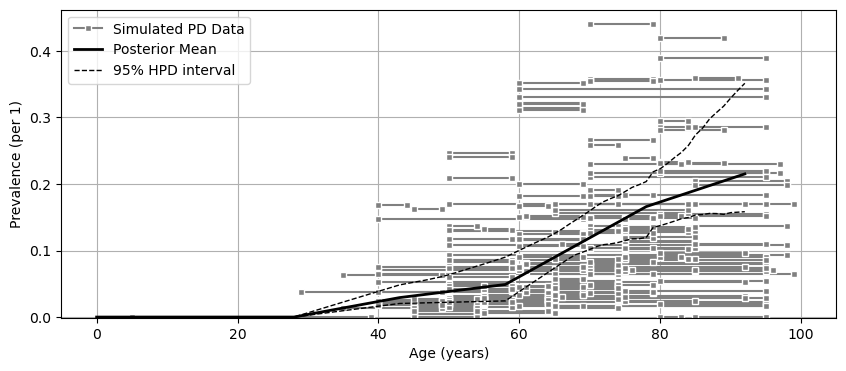

In [75]:
# ─────────────────────────────────────────────────────────────────────────────
# Step 4: 데이터 바(Observation Data) 시각화
# ─────────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(10, 4))
dismod_mr_pymc5.plot.data_bars(
    mr_model.get_data('p'),
    color='grey',
    label='Simulated PD Data'
)

# ─────────────────────────────────────────────────────────────────────────────
# Step 5: predict_for 호출하여 posterior‐predictive draws 생성
#         → 반드시 vars=mr_model.vars['p']를 넘겨야 mu_age 등이 존재합니다.
# ─────────────────────────────────────────────────────────────────────────────
pred = dismod_mr_pymc5.model.predict_for(
    model=mr_model,
    parameters=mr_model.parameters['p'],
    root_area='Global',
    root_sex='Both',
    root_year=2009,
    area='Global',
    sex='Female',
    year=2005,
    population_weighted=1.0,
    vars=mr_model.vars['p'],   # ← 여기서 'mu_age' 키가 반드시 있어야 합니다
    lower=0.0,
    upper=1.0
)

# ─────────────────────────────────────────────────────────────────────────────
# Step 6: 95% HPD(Highest Posterior Density) 계산 및 시각화
# ─────────────────────────────────────────────────────────────────────────────
hpd = pm.stats.hdi(pred, hdi_prob=0.95)
ages = np.arange(pred.shape[1])

plt.plot(
    ages,
    pred.mean(axis=0),
    'k-', linewidth=2,
    label='Posterior Mean'
)
plt.plot(
    ages,
    hpd[:, 0],
    'k--', linewidth=1,
    label='95% HPD interval'
)
plt.plot(
    ages,
    hpd[:, 1],
    'k--', linewidth=1
)

plt.xlabel('Age (years)')
plt.ylabel('Prevalence (per 1)')
plt.grid()
plt.legend(loc='upper left')
plt.axis(ymin=-0.001, xmin=-5, xmax=105)



# ─────────────────────────────────────────────────────────────────────────────
# Step 7: 예시—500번째 posterior draw의 연령 96~100 구간 값 출력
# ─────────────────────────────────────────────────────────────────────────────
# print(pred[500, -5:])

In [76]:
p_only = mr_model  # store results for future comparison

In [53]:
# Trying again with 'offset_log_normal' rate_type

# ─────────────────────────────────────────────────────────────────────────────
# Step 1: age_specific_rate (model.asr) 호출 → pm_model, result_dict 반환
#         result_dict에는 {'p': ModelVars} 형태로 들어 있으므로, 실제 ModelVars는 result_dict['p']
# ─────────────────────────────────────────────────────────────────────────────
pm_model, result_dict = dismod_mr_pymc5.model.asr(
    mr_model,   # MRModel 인스턴스
    'p',         # data_type ('p' for prevalence)
    rate_type='offset_log_normal'
)

# 반드시 “result_dict['p']”를 뽑아서 사용해야 합니다.
vars_dict = result_dict['p']

# ─────────────────────────────────────────────────────────────────────────────
# Step 2: vars_dict를 MRModel.vars에 저장
# ─────────────────────────────────────────────────────────────────────────────
mr_model.vars['p'] = vars_dict

# ─────────────────────────────────────────────────────────────────────────────
# Step 3: fit.asr 호출 → pm_model로 샘플링 → mr_model.idata에 InferenceData 저장
# ─────────────────────────────────────────────────────────────────────────────
map_estimate, idata = dismod_mr_pymc5.fit.asr(
    mr_model=mr_model,
    pm_model=pm_model,
    data_type='p',
    verbose=True,
    draws=1000,    # 테스트용: posterior 샘플 개수
    tune=500,      # 테스트용: tuning 단계
    chains=2,
    cores=4
)



[sigma_alpha_p_1, sigma_alpha_p_2, sigma_alpha_p_3, sigma_alpha_p_1, sigma_alpha_p_2, sigma_alpha_p_3, sigma_alpha_p_2, sigma_alpha_p_3, sigma_alpha_p_3, sigma_alpha_p_3, sigma_alpha_p_2, sigma_alpha_p_3, sigma_alpha_p_2, sigma_alpha_p_3, sigma_alpha_p_3, sigma_alpha_p_3, sigma_alpha_p_3, sigma_alpha_p_3, sigma_alpha_p_3, sigma_alpha_p_1, sigma_alpha_p_2, sigma_alpha_p_1, sigma_alpha_p_2, sigma_alpha_p_2, sigma_alpha_p_1, sigma_alpha_p_2, sigma_alpha_p_3, sigma_alpha_p_3, sigma_alpha_p_2, sigma_alpha_p_3]
==== verbose mode enabled ====


/Users/Dev/AMD/dismod_mr_migrated/dismod_mr_pymc5/fit.py:91: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  idata = pm.sample(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [gamma_p_0, gamma_p_1, gamma_p_2, gamma_p_3, gamma_p_4, gamma_p_5, sigma_alpha_p_0_z, sigma_alpha_p_1_z, sigma_alpha_p_2_z, sigma_alpha_p_3_z, sigma_alpha_p_4_z, alpha_p_Central Europe, Eastern Europe, and Central Asia, alpha_p_Eastern Europe, alpha_p_Russian Federation, alpha_p_High-income, alpha_p_Australasia, alpha_p_Australia, alpha_p_High-income Asia Pacific, alpha_p_Japan, alpha_p_Republic of Korea, alpha_p_Singapore, alpha_p_High-income North America, alpha_p_United States of America, alpha_p_Western Europe, alpha_p_Germany, alpha_p_Iceland, alpha_p_Ireland, alpha_p_Italy, alpha_p_Netherlands, alpha_p_Spain, alpha_p_North Africa and Middle East, alpha_p_Iran (Islamic Re

Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 147 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


==== asr reached the end ====


/var/folders/67/dbhlxds92p10kn5lvnqq1mf00000gn/T/ipykernel_30095/2820064040.py:33: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hpd = pm.stats.hdi(pred, hdi_prob=0.95)


(-5.0, 105.0, -0.001, 0.462)

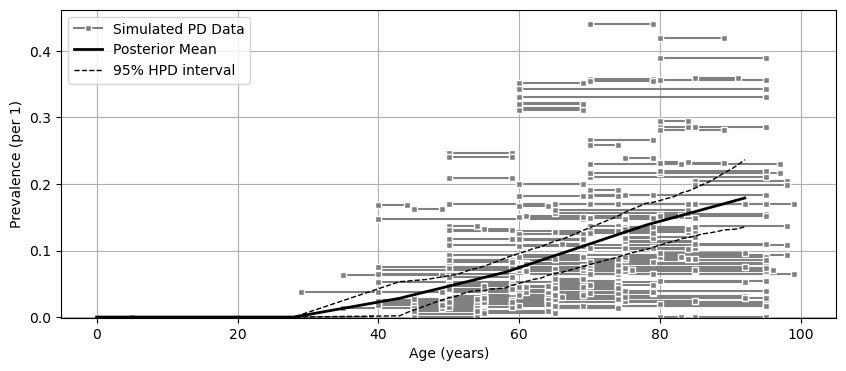

In [54]:
# ─────────────────────────────────────────────────────────────────────────────
# Step 4: 데이터 바(Observation Data) 시각화
# ─────────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(10, 4))
dismod_mr_pymc5.plot.data_bars(
    mr_model.get_data('p'),
    color='grey',
    label='Simulated PD Data'
)

# ─────────────────────────────────────────────────────────────────────────────
# Step 5: predict_for 호출하여 posterior‐predictive draws 생성
#         → 반드시 vars=mr_model.vars['p']를 넘겨야 mu_age 등이 존재합니다.
# ─────────────────────────────────────────────────────────────────────────────
pred = dismod_mr_pymc5.model.predict_for(
    model=mr_model,
    parameters=mr_model.parameters['p'],
    root_area='Global',
    root_sex='Both',
    root_year=2009,
    area='Global',
    sex='Female',
    year=2005,
    population_weighted=1.0,
    vars=mr_model.vars['p'],   # ← 여기서 'mu_age' 키가 반드시 있어야 합니다
    lower=0.0,
    upper=1.0
)

# ─────────────────────────────────────────────────────────────────────────────
# Step 6: 95% HPD(Highest Posterior Density) 계산 및 시각화
# ─────────────────────────────────────────────────────────────────────────────
hpd = pm.stats.hdi(pred, hdi_prob=0.95)
ages = np.arange(pred.shape[1])

plt.plot(
    ages,
    pred.mean(axis=0),
    'k-', linewidth=2,
    label='Posterior Mean'
)
plt.plot(
    ages,
    hpd[:, 0],
    'k--', linewidth=1,
    label='95% HPD interval'
)
plt.plot(
    ages,
    hpd[:, 1],
    'k--', linewidth=1
)

plt.xlabel('Age (years)')
plt.ylabel('Prevalence (per 1)')
plt.grid()
plt.legend(loc='upper left')
plt.axis(ymin=-0.001, xmin=-5, xmax=105)



# ─────────────────────────────────────────────────────────────────────────────
# Step 7: 예시—500번째 posterior draw의 연령 96~100 구간 값 출력
# ─────────────────────────────────────────────────────────────────────────────
# print(pred[500, -5:])

This estimate shows the nonlinear increase in prevalence as a function of age, where the slope of the
curve increases at age 60.  A nonlinear estimate like this is possible thanks to DisMod-MR's piecewise linear
spline model.

The age-standardizing model for heterogeneous age groups is also important for
such settings; a naive approach, such as using the age interval midpoint, would result in under-estimating
the prevalence for age groups that include both individuals older and younger than 60.


The exact age where the slope of the curve changes is _not_ entirely data driven in this example.  The knots
in the piecewise linear spline model were chosen a priori, on the following grid:

In [55]:
mr_model.parameters['p']['parameter_age_mesh']

[2, 30, 45, 60, 80, 94]

A sparse grid allows faster computation, but a dense grid allows more expressive age pattens.  Choosing
the proper balance is one challenge of a DisMod-MR analysis.  This is especially true for sparse,
noisy data, where too many knots allow the model to follow noisy idiosyncrasies of the data.  DisMod-MR
allows for penalized spline regression to help with this choice.

The country-level random effects in this model capture country-to-country variation in PD prevalence.
This variation is not visible in the graphic above, which shows the regional aggregation of country-level
estimates (using a population weighted average that takes uncertainty into account).

The country-level random effects take the form of intercept shifts in log-prevalence space, with values
showing in the following:

In [56]:
df = pd.DataFrame(index=[alpha_i.__name__ for alpha_i in mr_model.vars['p']['alpha']],
                      columns=['mean', 'lb', 'ub'])
for alpha_i in mr_model.vars['p']['alpha']:
    trace = alpha_i.trace()
    hpd = mc.utils.hpd(trace, .05)
    df.loc[alpha_i.__name__] = (np.mean(trace), hpd[0], hpd[1])

AttributeError: 'TensorVariable' object has no attribute '__name__'

In [ ]:
print(np.round(df.astype(float),3).sort_values('mean', ascending=False))

              mean     lb     ub
alpha_p_NOR  0.869  0.641  1.155
alpha_p_DEU  0.811  0.516  1.057
alpha_p_ITA  0.705  0.419  1.056
alpha_p_FRA  0.696  0.410  1.005
alpha_p_ISL  0.444  0.221  0.724
alpha_p_GBR -0.095 -0.506  0.279
alpha_p_FIN -0.153 -0.515  0.416
alpha_p_PRT -0.251 -0.517  0.098
alpha_p_ESP -0.280 -0.635  0.139
alpha_p_NLD -0.558 -0.885 -0.247
alpha_p_IRL -0.829 -1.193 -0.459
alpha_p_GRC -1.014 -1.284 -0.674


The fourth feature of the model which I want to draw attention to here is the negative binomial model of data,
which deals with measurements of zero prevalence in a principled way.  Prevalence studies are reporting transformations
of count data, and count data can be zero.  In the case of prevalence of PD in 30- to 40-year-olds, it often _will_ be zero.

In [ ]:
mr_model.get_data('p').sort_values('age_start').filter(['age_start', 'age_end', 'area', 'value']).head(15)

,age_start,age_end,area,value
4413,35,74,DEU,0.018842
4420,35,74,DEU,0.043658
4427,35,74,DEU,0.000919
4434,35,74,DEU,0.000919
4441,35,74,DEU,0.001838
4448,35,74,DEU,0.045496
4455,35,74,DEU,0.024816
4462,35,74,DEU,0.018842
4469,35,74,DEU,0.043658
4476,35,74,DEU,0.000919


ValueError: ('ExtractDiag needs an input with 2 or more dimensions', value_constrained_mu_age_p)

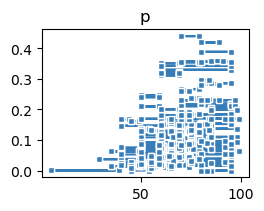

In [32]:
mr_model.plot()

for y in range(1990,2010,2):
    color = plt.cm.Spectral((y-1990.)/20.)
    plt.plot(mr_model.predict_for('p', 'Global', 'Both', y).mean(0), color=color, label=str(y))
    dismod_mr.plot.data_bars(df=mr_model.input_data[mr_model.input_data['year'] == y], color=color, label='')
plt.legend(loc=(1.05,.05));

The negative binomial model has an appropriately skewed distribution, where prevalence measurements 
of zero are possible, but measurements of less than zero are not possible.  To demonstrate how this
functions, the next figure shows the "posterior predictive distribution" for the measurements above,
i.e. sample values that the model predicts would be found of the studies were conducted again under
the same conditions.

In [68]:
pred = mr_model.vars['p']['p_pred'].trace()
obs = np.array(mr_model.vars['p']['p_obs'].value)
ess = np.array(mr_model.vars['p']['p_obs'].parents['n'])

Text(0.5, 1.0, 'Posterior Predictive distribution')

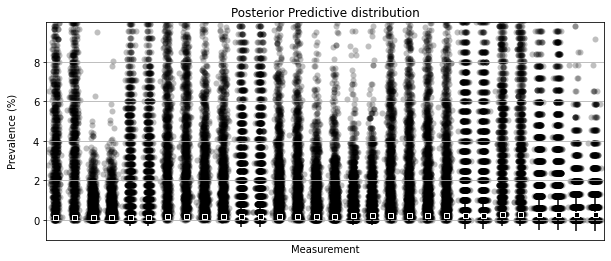

In [ ]:
plt.figure(figsize=(10,4))

sorted_indices = obs.argsort().argsort()
jitter = mc.rnormal(0, .1**-2, len(pred))

for i,s_i in enumerate(sorted_indices):
    plt.plot(s_i+jitter, pred[:, i], 'ko', mew=0, alpha=.25, zorder=-99)

plt.errorbar(sorted_indices, obs, yerr=1.96*np.sqrt(obs*(1-obs)/ess), fmt='ks', mew=1, mec='white', ms=5)

plt.xticks([])
plt.xlabel('Measurement')
plt.ylabel('Prevalence (%)\n', ha='center')
plt.yticks([0, .02, .04, .06, .08], [0, 2, 4, 6, 8])
plt.axis([25.5,55.5,-.01,.1])
plt.grid()
plt.title('Posterior Predictive distribution')

Additional features of DisMod-MR
--------------------------------

Four additional features of DisMod-MR that are important for many settings are:

* informative priors
* fixed effects to cross-walk between different studies
* fixed effects to predict out of sample
* fixed effects to explain the level of variation

Informative priors are useful for modeling disease with less data available than PD, for example to include
information that prevalence is zero for youngest ages, or than prevalence must be increasing as a function of
age between certain ages.

The informative priors are also key to the "empirical Bayes" approach to modeling age-specific differences between
difference GBD regions.  In this setting, a model using all the world's data is used to produce estimates for each region,
and these estimates are used as priors in region-specific models together with the data relevant to that region only.

"Cross-walk" fixed effects can correct for biases introduced by multiple outcome measures.  For example, in the PD dataset,

In [70]:
mr_model = dismod_mr.data.load('amd_sim_data')

In [71]:
crosswalks = list(mr_model.input_data.filter(like='x_cv').columns)
groups = mr_model.get_data('p').groupby(crosswalks)

ValueError: No group keys passed!

In [ ]:
crosswalks

[]

In [21]:
np.round(groups['value'].describe(),3).unstack()['mean'].fillna('-')

x_cv_representative                              0      1
x_cv_ascertainment x_cv_diagnostic_criteria              
0                  0                         0.006      -
                   1                         0.009      -
1                  0                         0.004      -
                   1                         0.004  0.009

Incorporating data on parameters other than prevalence
------------------------------------------------------

So far this example has focused on modeling the prevalence of PD from the
prevalence data alone.  However, this represents about half of the available
data.  There is also information on incidence, SMR, and CSMR, which has not
yet been incorporated.

DisMod-MR is capable of including all of the available data, using a compartmental
model of disease moving through a population.  This model formalizes the observation
that prevalent cases must once have been incident cases, and continue to be prevalent
cases until remission or death.

In this model, incidence, remission, and excess-mortality are age-standardizing negative binomial random effect spline models,
while prevalence, SMR, CSMR, and other parameters come from the solution to a system of ordinary differential equations.

The results of this model are smoother prevalence curves that take longer to calculate.

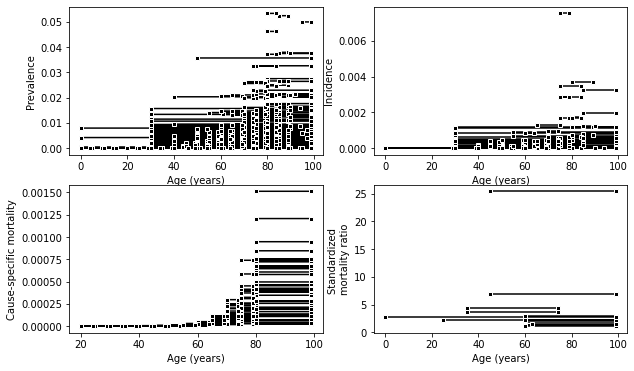

In [22]:
plt.figure(figsize=(10,6))

plt.subplot(2,2,1); dismod_mr.plot.data_bars(mr_model.get_data('p')); plt.xlabel('Age (years)'); plt.ylabel('Prevalence')
plt.subplot(2,2,2); dismod_mr.plot.data_bars(mr_model.get_data('i')); plt.xlabel('Age (years)'); plt.ylabel('Incidence')
plt.subplot(2,2,3); dismod_mr.plot.data_bars(mr_model.get_data('csmr')); plt.xlabel('Age (years)'); plt.ylabel('Cause-specific mortality')
plt.subplot(2,2,4); dismod_mr.plot.data_bars(mr_model.get_data('smr')); plt.xlabel('Age (years)'); plt.ylabel('Standardized \nmortality ratio');

In [23]:
mr_model.input_data.columns

Index(['index', 'age_end', 'age_start', 'age_weights', 'area', 'data_type',
       'effective_sample_size', 'lower_ci', 'sex', 'standard_error',
       'upper_ci', 'value', 'x_cv_ascertainment', 'x_cv_diagnostic_criteria',
       'x_cv_representative', 'year_end', 'year_start'],
      dtype='object')

In [24]:
mr_model.vars += dismod_mr.model.consistent(mr_model)
%time dismod_mr.fit.consistent(model)

using stored FE for beta_i_x_cv_ascertainment x_cv_ascertainment {'mu': 0, 'dist': 'Normal', 'sigma': 0.0001}
using stored FE for beta_i_x_cv_diagnostic_criteria x_cv_diagnostic_criteria {'mu': 0, 'dist': 'Normal', 'sigma': 0.0001}
using stored FE for beta_i_x_cv_representative x_cv_representative {'mu': 0, 'dist': 'Normal', 'sigma': 0.0001}
using stored FE for beta_i_x_sex x_sex {'mu': 0, 'dist': 'Normal', 'sigma': 0.0001}
using stored FE for beta_r_x_cv_ascertainment x_cv_ascertainment {'mu': 0, 'dist': 'Normal', 'sigma': 0.0001}
using stored FE for beta_r_x_cv_diagnostic_criteria x_cv_diagnostic_criteria {'mu': 0, 'dist': 'Normal', 'sigma': 0.0001}
using stored FE for beta_r_x_cv_representative x_cv_representative {'mu': 0, 'dist': 'Normal', 'sigma': 0.0001}
using stored FE for beta_r_x_sex x_sex {'mu': 0, 'dist': 'Normal', 'sigma': 0.0001}
using stored FE for beta_f_x_cv_ascertainment x_cv_ascertainment {'mu': 0, 'dist': 'Normal', 'sigma': 0.0001}
using stored FE for beta_f_x_cv_di

/opt/anaconda3/envs/dismod_mr/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


using stored FE for beta_X_x_cv_ascertainment x_cv_ascertainment {'mu': 0, 'dist': 'Normal', 'sigma': 0.0001}
using stored FE for beta_X_x_cv_diagnostic_criteria x_cv_diagnostic_criteria {'mu': 0, 'dist': 'Normal', 'sigma': 0.0001}
using stored FE for beta_X_x_cv_representative x_cv_representative {'mu': 0, 'dist': 'Normal', 'sigma': 0.0001}
using stored FE for beta_X_x_sex x_sex {'mu': 0, 'dist': 'Normal', 'sigma': 0.0001}
fitting submodels


/opt/anaconda3/envs/dismod_mr/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
fitting all stochs

finding step covariances
. . . . . . . . . . . . . . . . . . . . . . . . . 
sampling from posterior distribution

Halting at iteration  21  of  2000
CPU times: user 14min 34s, sys: 5min, total: 19min 35s
Wall time: 4min 15s


(<pymc.NormalApproximation.MAP at 0x7fc25acb6390>,
 <pymc.MCMC.MCMC at 0x7fc25acb6208>)

/homes/abie/.conda/envs/dismod_mr/lib/python3.6/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


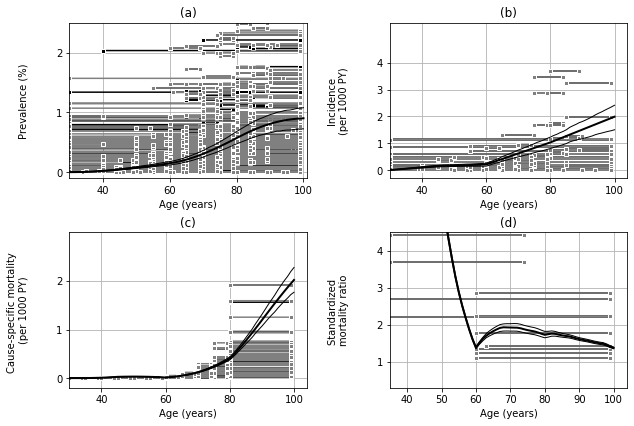

In [25]:
plt.figure(figsize=(10,6))

plt.subplot(2,2,1); dismod_mr.plot.data_bars(mr_model.get_data('p')); plt.xlabel('Age (years)'); plt.ylabel('Prevalence')
plt.subplot(2,2,2); dismod_mr.plot.data_bars(mr_model.get_data('i')); plt.xlabel('Age (years)'); plt.ylabel('Incidence')
plt.subplot(2,2,3); dismod_mr.plot.data_bars(mr_model.get_data('csmr')); plt.xlabel('Age (years)'); plt.ylabel('Cause-specific mortality')
plt.subplot(2,2,4); dismod_mr.plot.data_bars(mr_model.get_data('smr')); plt.xlabel('Age (years)'); plt.ylabel('Standardized \nmortality ratio')
param_list = [dict(type='p', title='(a)', ylabel='Prevalence (%)', yticks=([0, .01, .02], [0, 1, 2]), axis=[30,101,-0.001,.025]),
          dict(type='i', title='(b)', ylabel='Incidence \n(per 1000 PY)', yticks=([0, .001,.002, .003, .004], [0, 1, 2, 3, 4]), axis=[30,104,-.0003,.0055]),
          dict(type='pf', title='(c)', ylabel='Cause-specific mortality \n(per 1000 PY)', yticks=([0, .001,.002], [0, 1, 2]), axis=[30,104,-.0002,.003]),
          dict(type='smr', title='(d)', ylabel='Standardized \nmortality ratio', yticks=([1, 2, 3,4, ], [1, 2,3, 4]), axis=[35,104,.3,4.5]),
          ]

for i, params in enumerate(param_list):
    ax = plt.subplot(2,2,i+1)
    if params['type'] == 'pf': dismod_mr.plot.data_bars(mr_model.get_data('csmr'), color='grey')
    else: dismod_mr.plot.data_bars(mr_model.get_data(params['type']), color='grey')
    
    if params['type'] == 'smr': mr_model.pred = dismod_mr.model.predict_for(mr_model, mr_model.parameters.get('smr', {}), 'all', 'female', 2005, 
                                                               'GBR', 'female', 2005, 1., mr_model.vars['smr'], 0., 100.).T
    else : mr_model.pred = dismod_mr.model.predict_for(mr_model, mr_model.parameters[params['type']],
                                                       'all', 'female', 2005, 
                                                       'GBR', 'female', 2005, 1., mr_model.vars[params['type']], 0., 1.).T
    
    plt.plot(np.arange(101), mr_model.pred.mean(axis=1), 'k-', linewidth=2, label='Posterior Mean')
    hpd = mc.utils.hpd(mr_model.pred.T, .05)
    plt.plot(np.arange(101), hpd[0], 'k-', linewidth=1, label='95% HPD interval')
    plt.plot(np.arange(101), hpd[1], 'k-', linewidth=1)

    plt.xlabel('Age (years)')
    plt.ylabel(params['ylabel']+'\n\n', ha='center')
    plt.axis(params.get('axis', [-5,105,-.005,.06]))
    plt.yticks(*params.get('yticks', ([0, .025, .05], [0, 2.5, 5])))
    plt.title(params['title'])
    plt.grid()
    
plt.subplots_adjust(hspace=.35, wspace=.35, top=.97)

In [26]:
p_with = mr_model

The most notable difference between the estimates from this model and from the model
that used prevalence data only is that this model produces estimates of incidence and
mortality in addition to prevalence.  In many cases, the model also produces estimates
of the remission rate as well, but there is no remission of PD, so the estimates of zero
are not very interesting in this example.  It is another place that informative priors are useful,
however.

There are also differences between the means and uncertainty intervals estimated by these methods,
which show that the additional data is important.  Although the prevalence data alone predicts 
age-specific prevalence that peaks at 2%, when the incidence and mortality data is also included, the
maximum prevalence is a bit lower, closer to 1.5%.

In [27]:
p1 = dismod_mr.model.predict_for(p_only, mr_model.parameters['p'],
                                    'all', 'total', 'all', 
                                    'GBR', 'female', 2005, 1.,
                                    p_only.vars['p'], 0., 1.)

p2 = dismod_mr.model.predict_for(p_with, mr_model.parameters['p'],
                                    'all', 'total', 'all', 
                                    'GBR', 'female', 2005, 1.,
                                    p_with.vars['p'], 0., 1.)

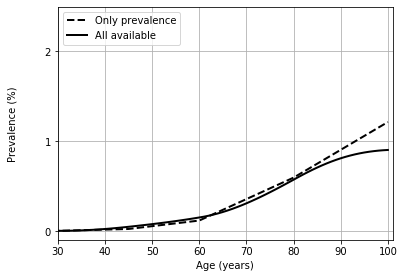

In [28]:
plt.plot(p1.mean(axis=0), 'k--', linewidth=2, label='Only prevalence')
plt.plot(p2.mean(axis=0), 'k-', linewidth=2, label='All available')

plt.xlabel('Age (years)')
plt.ylabel('Prevalence (%)\n\n', ha='center')
plt.yticks([0, .01, .02], [0, 1, 2])
plt.axis([30,101,-0.001,.025])
plt.legend(loc='upper left')
plt.grid()

plt.subplots_adjust(top=.97, bottom=.16)

Because the data is so noisy, the differences between the mean estimates of these different models are not significant; the posterior distributions
have considerable overlap.  At age 80, for example, the posterior distributions for age-80 prevalence are estimated as the following:

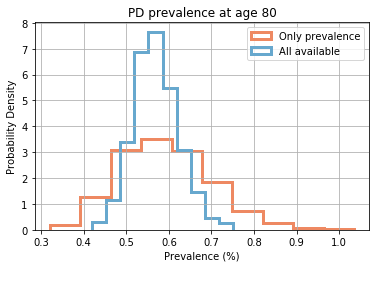

In [29]:
plt.hist(100*p1[:,80], density=True, histtype='step', label='Only prevalence', linewidth=3, color=np.array([239., 138., 98., 256.])/256)
plt.hist(100*p2[:,80], density=True, histtype='step', label='All available', linewidth=3, color=np.array([103, 169, 207, 256.])/256)
plt.title('PD prevalence at age 80')
plt.xlabel('Prevalence (%)\n\n', ha='center')
plt.ylabel('Probability Density')
plt.legend(loc='upper right')
plt.grid()

plt.subplots_adjust(bottom=.16)

Conclusion
==========

I hope that this example is a quick way to see the strengths and weaknesses of DisMod-MR.
This model is particularly suited for estimating descriptive epidemiology of diseases
with sparse, noisy data from multiple, incompatible sources.

I am currently working to make it faster, as well as to improve the capabilities for modeling
changes between regions over time.

In [19]:
!date

Tue Apr 29 15:47:18 EDT 2025


In [43]:
!pip list

Package                       Version     Editable project location
----------------------------- ----------- ---------------------------------
anyio                         3.3.2
appnope                       0.1.3
argon2-cffi                   21.1.0
async_generator               1.10
attrs                         22.2.0
Babel                         2.11.0
backcall                      0.2.0
backports.functools-lru-cache 2.0.0
bleach                        6.1.0
brotlipy                      0.7.0
certifi                       2021.5.30
cffi                          1.14.6
charset-normalizer            2.1.1
contextvars                   2.4
cryptography                  35.0.0
cycler                        0.11.0
dataclasses                   0.8
decorator                     5.1.1
defusedxml                    0.7.1
dismod-mr                     1.1.2.7     /Users/jeonsang-eon/dismod_mr/src
entrypoints                   0.4
et-xmlfile                    1.1.0
idna                 